In [ ]:
# Install the required libraries.
!pip install torch torchvision
!pip install Pillow==9.4.0

In [ ]:
# Activate matplotlib interactive support.
%matplotlib inline

# Import the required libraries.
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy

In [ ]:
# VGG19 is a convolutional neural network, comprised of 16 convolution and 3 fully connected layers, that classifies images into 1000 categories/classes.
# Import only the VGG19 pretrained features model.
vgg19_model = models.vgg19(pretrained = True).features

for param in vgg19_model.parameters():
  param.requires_grad_(False) # Set the parameter as constant, in order to not be changed by the back-propagation process, which normally updates the weights.

In [ ]:
# Use the GPU for the model, if it is available. Otherwise, use the CPU.
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

# Attach the VGG19 model to the device (GPU or CPU).
vgg19_model.to(device)

In [ ]:
# Load an image with the maximum size of 600x600 pixels.
def load_image(image_path, image_max_size = 600, image_shape = None):
  image = Image.open(image_path) # Grab the image from the folder path.
  image = image.convert('RGB') # Convert the image to RGB color space format.

  #Check that the image size does not exceed 600x600 pixels.
  if max(image.size) > image_max_size:
    size = image_max_size # Reduce size to the maxim defined value of 600x600 pixels. 
  else:
    size = max(image.size) # Size remains unchanged, since it is already smaller than 600x600 pixels.

  # Tranform the image to make it compatible with our model and PyTorch. 
  image_transform = transforms.Compose([
      transforms.Resize(size), # Resize the image to a maximum size of 600x600 pixels.
      transforms.ToTensor(), # Convert the image into a Tensor multi-dimensional array.
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the image with mean and standard deviation.       
  ])

  image = image_transform(image) # Transform the image.
  image = image.unsqueeze(0) # Add a new dimension at the 0th position of the Tensor.

  return image

In [ ]:
target_image = load_image('Noah.jpg') # Load the target image.
target_image = target_image.to(device) # Use the GPU, if available.

style_image = load_image('Yoshida.jpg') # Load the image from which we want to inherit the art style, that will be applied upon the target image.
style_image = style_image.to(device) # Use the GPU, if available.

In [ ]:
# Convert Tensor into a numpy array format.
def image_convert(tensor):
  image = tensor.to("cpu") # Move the Tensor to CPU.
  image = image.clone().detach() # Create a copy of the Tensor and detach it.
  image = image.numpy( ) # Convert image to a numpy array.
  image = image.squeeze() # Remove any dimensions of size 1.
  image = image.transpose(1, 2, 0) # Transpose the axes of the numpy array.
  image = image * numpy.array((0.5, 0.5, 0.5)) + numpy.array((0.5, 0.5, 0.5)) # Multiply and add the values of the image, so that pixels values are within the [0,1] range.
  image = image.clip(0, 1) # Any values < 0 are set to 0, and any values > 1 are set to 1.

  return image

(-0.5, 599.5, 832.5, -0.5)

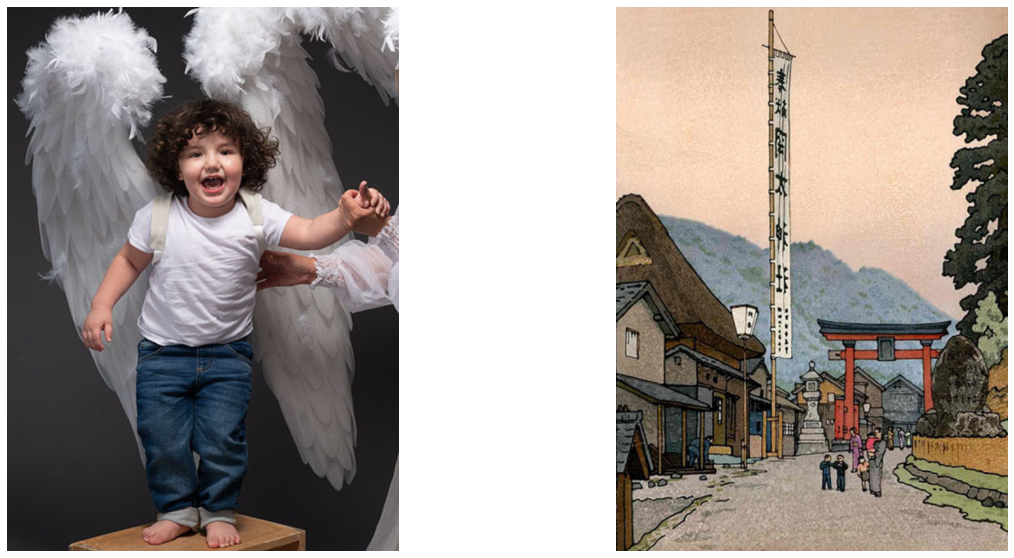

In [ ]:
fig, (axis_1, axis_2) = plt.subplots(1, 2, figsize = (20, 10)) # Create a figure and a set of subplots, on 1 row and 2 columns.

target_image = image_convert(target_image) # Convert the target image into a numpy array format.
axis_1.imshow(target_image) # Display image.
axis_1.axis('off') # Turn off axis lines and labels, for better visibility.

style_image = image_convert(style_image) # Convert the style image into a numpy array format.
axis_2.imshow(style_image) # Display image.
axis_2.axis('off') # Turn off axis lines and labels, for better visibility.

In [ ]:
# Extract the features that will capture the image style.
def get_image_features(image, model):
  # Select from the model Sequential array (see above 'vgg19_model.to(device)' code), only the features/layers (convolutional) that are the most relevant for us. 
  layers = {'0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2', # Content extration.
            '28': 'conv5_1'}

  features = {} # Empty dictionary that will store all the extracted features.

  # Iterate the model layers name and information.
  for name, layer in model._modules.items():
    image = layer(image) # Feed the image through each layer of the model/network.

    # Check if the name is part of the layers dictionary, since we want to capture only the features from the 6 layers.
    if name in layers:
      features[layers[name]] = image # Append to features dictionay, the layer name and information (features). 

  return features

In [ ]:
target_image_features = get_image_features(target_image, vgg19_model)
style_image_features = get_image_features(style_image, vgg19_model)

In [ ]:
# Multiply a matrix with the transpose matrix.
def gram_matrix(tensor):
  _, depth, height, width = tensor.size() # Unpack the Tensor dimensions. We can ignore the batch value.
  tensor = tensor.view(depth, height * width) # Two-dimensional Tensor.
  gram_matrix = torch.mm(tensor, tensor.t()) # Multiply the Tensor matrix with the transpose.

  return gram_matrix

In [ ]:
# Mapp each extracted feature/layer to the gram matrix.
style_grams = {layer: gram_matrix(style_image_features[layer]) for layer in style_image_features}

In [ ]:
# Define the weights of the style image. Conv1_1 is the most important, so we set the weight to 1.
style_image_weights = {'conv1_1': 1.0,
                        'conv2_1': 0.75,
                        'conv3_1': 0.2,
                        'conv4_1': 0.2,
                        'conv5_1': 0.2}

# Define weigth and ratio between target and style image.
target_image_weight = 1
style_image_weight = 1e6

In [ ]:
output_image = target_image.clone() # Clone the target image.
output_image = output_image.requires_grad_(True) # Enable gradients so that the output image is being adjusted alongside the optimization process.
output_image = output_image.to(device)

In [ ]:
show_output_image_progress = 300 # Display the output image every 300 iterations, to see the progress in real time.
optimizer = optim.Adam([output_image], lr = 0.003) # Optimize the output image using the Adam algorithm, with a learning rate of 0.003.
steps = 2100 # Run the optimization code for 2100 steps.

height, width, rgb_channels = image_convert(output_image).shape # Unpack the output image.
image_array = numpy.empty(shape = (300, height, width, rgb_channels)) # Store 300 frames of images, to visualize the optimization process.

capture_frame = steps/300 # Capture a frame, every 7 optimization steps.
counter = 0

Total Loss:  909843.5625
Iteration:  300


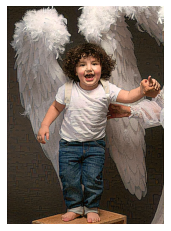

Total Loss:  585673.75
Iteration:  600


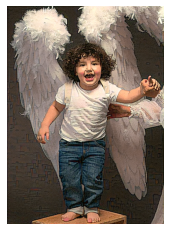

Total Loss:  410060.40625
Iteration:  900


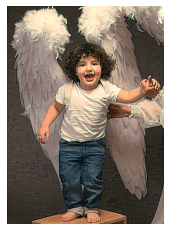

Total Loss:  292727.75
Iteration:  1200


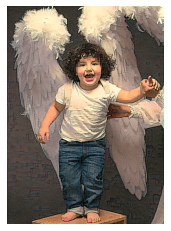

Total Loss:  212642.9375
Iteration:  1500


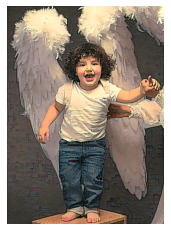

Total Loss:  156252.03125
Iteration:  1800


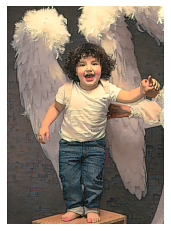

Total Loss:  115652.6484375
Iteration:  2100


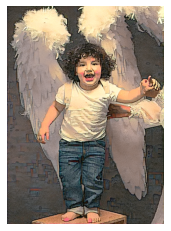

In [ ]:
# Iterate all the steps.
for step in range(1, steps + 1):
  output_image_features = get_image_features(output_image, vgg19_model)

  # Calculate the the difference between the output image vs target image.
  target_loss = torch.mean((output_image_features['conv4_2'] - target_image_features['conv4_2'])**2)

  style_loss = 0

  # Iterate all 5 layers. 
  for layer in style_image_weights:
    output_image_feature = output_image_features[layer]
    output_gram = gram_matrix(output_image_feature)
    style_gram = style_grams[layer]
    
    # Calculate the difference between output image matrix vs style image matrix, for all 5 layers.
    layer_style_loss = style_image_weights[layer] * torch.mean((output_gram - style_gram)**2)

    _, depth, height, width = output_image_feature.shape # Unpack the output image.
    style_loss = style_loss + layer_style_loss / (depth * height * width) # Normalize the loss to obtain the unit loss.

  total_loss = target_loss * target_image_weight + style_loss * style_image_weight # Calculate the total loss.

  optimizer.zero_grad() # Reset the gradients to zero, before the optimizer computes the new batch of data.
  total_loss.backward() # Update the model parameters/weights to minimize the total loss.
  optimizer.step() # Update the weights for each iteration. Which each iteration we are going to apply more style to the output image.

  # Display output image every 300 iterations.
  if step % show_output_image_progress == 0:
    print ('Total Loss: ', total_loss.item())
    print ('Iteration: ', step)
    
    plt.imshow(image_convert(output_image))
    plt.axis("off")
    plt.show()

  # Capture frame every 7 optimization steps.
  if step % capture_frame == 0:
    image_array[counter] = image_convert(output_image)
    counter = counter + 1

(-0.5, 599.5, 832.5, -0.5)

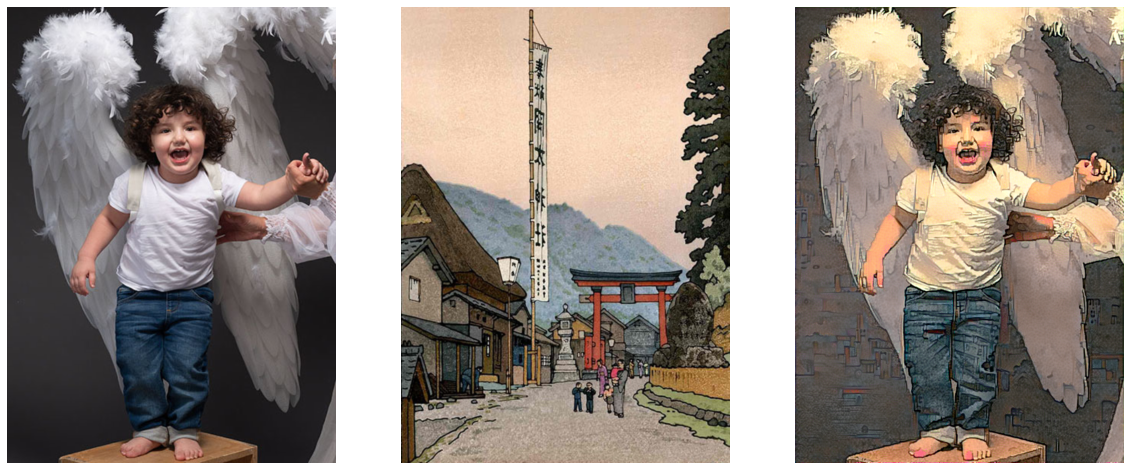

In [ ]:
# Display all 3 images, side by side.
fig, (axis_1, axis_2, axis_3) = plt.subplots(1, 3, figsize = (20, 10))

axis_1.imshow(image_convert(target_image))
axis_1.axis('off')

axis_2.imshow(image_convert(style_image))
axis_2.axis('off')

axis_3.imshow(image_convert(output_image))
axis_3.axis('off')